In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
import wandb
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from glob import glob
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import os

from opf.utils import model_from_parameters

%aimport opf
%aimport opf.modules
%aimport opf.constraints
%aimport opf.utils
%aimport opf.power
%aimport opf.plot

# fix issues with figures using underscores in their names
mpl.rcParams['text.usetex'] = False

In [4]:
api = wandb.Api()
run = api.run("damowerko/opf/2lllzf30")

root_dir = "../"
data_dir = root_dir + "data/"
log_dir = root_dir + "logs/"

save_dir = f"../figures/{run.config['case_name']}/"
os.makedirs(save_dir, exist_ok=True)


def save(title: str, fig=plt):
    fig.savefig(save_dir + f"{title}.png")
    fig.savefig(save_dir + f"{title}.pdf")


barrier, trainer, dm = model_from_parameters(
    run.config, gpus=0, logger=None, data_dir=data_dir, patience=100
)
checkpoint_directory = f"{log_dir}opf/{run.id}/checkpoints/"
print("Searching in", checkpoint_directory)

files = list(glob(checkpoint_directory + "*.ckpt"))
print("Found", files)
assert len(files) == 1
checkpoint = torch.load(files[0], map_location=lambda storage, loc: storage)

barrier.load_state_dict(checkpoint["state_dict"], strict=False)


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Searching in ../logs/opf/2lllzf30/checkpoints/
Found ['../logs/opf/2lllzf30/checkpoints/epoch=192-step=67936.ckpt']


/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1295: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


_IncompatibleKeys(missing_keys=[], unexpected_keys=['p_mask', 'q_mask', 'p_min', 'p_max', 'q_min', 'q_max', 'gen_matrix', 'p_coeff', 'q_coeff', 'load_matrix', 'vm_mask', 'vm_min', 'vm_max', 'base_kv', 'vad_mask', 'rate_a', 'vad_max', 'vad_min'])

In [5]:
from pytorch_lightning.callbacks import Callback

results = []
class CustomCallback(Callback):
    def on_test_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
            results.append({k: v.item() for k,v in outputs.items()})

barrier.double()
barrier.detailed_metrics = True
trainer.callbacks.append(CustomCallback())
trainer.test(barrier, datamodule=dm)
df = pd.DataFrame(results)

/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 100%|█████████▉| 796/798 [00:18<00:00, 46.59it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acopf/cost': 1.4139740467071533,
 'acopf/equality/bus_power/error_max': 0.0,
 'acopf/equality/bus_power/error_mean': 0.0,
 'acopf/equality/bus_power/loss': 8.910261861672097e-09,
 'acopf/equality/bus_power/rate': 0.0,
 'acopf/equality/error_max': 0.0,
 'acopf/equality/error_mean': 0.0,
 'acopf/equality/loss': 8.910261861672097e-09,
 'acopf/equality/rate': 0.0,
 'acopf/inequality/active_power/error_max': 0.0,
 'acopf/inequality/active_power/error_mean': 0.0,
 'acopf/inequality/active_power/loss': 0.0006164190708659589,
 'acopf/inequality/active_power/rate': 0.0,
 'acopf/inequality/backward_rate/error_max': 0.0,
 'acopf/inequality/backward_rate/error_mean': 0.0,
 'acopf/inequality/backward_rate/loss': 0.0044703409075737,
 'acopf/inequality/backward_rate/rate': 0.0,
 'acopf/inequality/error_max': 0.0,
 'acopf/inequality/erro

In [6]:
(df[["test/cost","test/inequality/rate"]].mean(),
df[[
    "test/inequality/error_max",
    "test/inequality/active_power/error_max",
    "test/inequality/reactive_power/error_max",
    "test/inequality/voltage_magnitude/error_max",
    "test/inequality/forward_rate/error_max",
    "test/inequality/backward_rate/error_max",
    "test/inequality/voltage_angle_difference/error_max",
]].max())

(test/cost               1.347088
 test/inequality/rate    0.002822
 dtype: float64,
 test/inequality/error_max                             0.092507
 test/inequality/active_power/error_max                0.000000
 test/inequality/reactive_power/error_max              0.000000
 test/inequality/voltage_magnitude/error_max           0.000000
 test/inequality/forward_rate/error_max                0.092507
 test/inequality/backward_rate/error_max               0.078466
 test/inequality/voltage_angle_difference/error_max    0.000000
 dtype: float64)

# Statistics

In [7]:
print(f"""
Mean violation rate: {df["test/inequality/rate"].max()}
Rate of any violation: {(df["test/inequality/rate"] > 1e-8).sum() / len(df)}
GNN Cost: {df["test/cost"].mean()}
IPOPT Cost: {df["acopf/cost"].mean()}
""")


Mean violation rate: 0.008130081300813009
Rate of any violation: 0.7380952380952381
GNN Cost: 1.3470881156891341
IPOPT Cost: 1.413974609483106



# Histograms

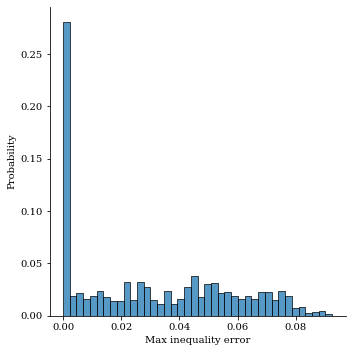

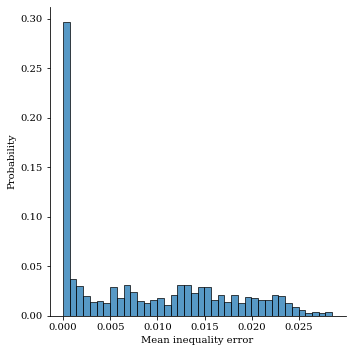

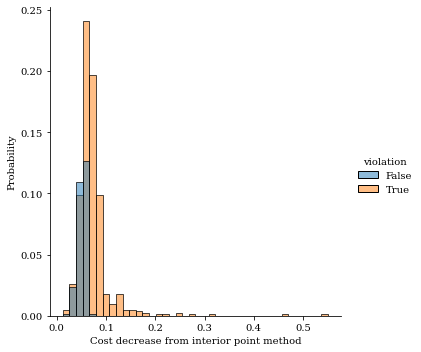

In [8]:
bins = 40

sns.displot(df, x="test/inequality/error_max", stat="probability", bins=bins)
plt.xlabel("Max inequality error")
save("error_max")

sns.displot(df, x="test/inequality/error_mean", stat="probability", bins=bins)
plt.xlabel("Mean inequality error")
save("error_mean")

# Cost improvement
df["test/cost/difference"] = df["acopf/cost"] - df["test/cost"]
df["violation"] = df["test/inequality/rate"] > 1e-8
sns.displot(df, x="test/cost/difference", hue="violation", stat="probability", bins=bins)
plt.xlabel("Cost decrease from interior point method")
save("costs")

# Visualizing Violations

In [9]:
sort_term = "test/inequality/error_max"
quantile = 1

s = df[sort_term]
index = (s.sort_values()[::-1] <= s.quantile(quantile)).idxmax()
print(sort_term, s[index])
print("Idx", index)
df.iloc[index][[
    "test/cost",
    "test/inequality/error_max",
    "test/inequality/active_power/error_max",
    "test/inequality/reactive_power/error_max",
    "test/inequality/voltage_magnitude/error_max",
    "test/inequality/forward_rate/error_max",
    "test/inequality/backward_rate/error_max",
    "test/inequality/voltage_angle_difference/error_max",
]]

test/inequality/error_max 0.09250700615196239
Idx 269


test/cost                                               1.34348
test/inequality/error_max                              0.092507
test/inequality/active_power/error_max                        0
test/inequality/reactive_power/error_max                      0
test/inequality/voltage_magnitude/error_max                   0
test/inequality/forward_rate/error_max                 0.092507
test/inequality/backward_rate/error_max               0.0784664
test/inequality/voltage_angle_difference/error_max            0
Name: 269, dtype: object

In [10]:
import opf.plot

dataset = list(dm.test_dataloader())
barrier.double()
load = dataset[index][0].double()

plots = opf.plot.plot_constraints(barrier, load, project=True)
for name in plots:
    save(name, fig=plots[name])

TypeError: plot_constraints() got an unexpected keyword argument 'project'

In [ ]:
forward_error = df.iloc[index]["test/inequality/forward_rate/error_max"]
backward_error = df.iloc[index]["test/inequality/backward_rate/error_max"]    

increase = 1 + torch.clamp((torch.maximum(Sf.abs(),St.abs()) - barrier.rate_a) / barrier.rate_a, min=0) \
    .squeeze().detach().numpy()
net = barrier.net_wrapper.net
original = net.line.copy()
barrier.net_wrapper.set_load_sparse(Sd.real.squeeze(), Sd.imag.squeeze())
net.line["max_i_ka"] *= increase
bus = torch.as_tensor(barrier.net_wrapper.optimal_ac()[0]).double().unsqueeze(0)
cost, constraints = barrier.optimal_power_flow(barrier.bus_from_polar(bus), load)
net.line = original

print("IPOPT Original Cost:", df.iloc[index]["acopf/cost"])
print("IPOPT Relaxed Cost:", cost.item())
print("GNN Cost", df.iloc[index]["test/cost"])

NameError: name 'Sf' is not defined